In [1]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/lorenz_long_x.csv'

import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

Mounted at /content/drive


Data shape: (1048575,)


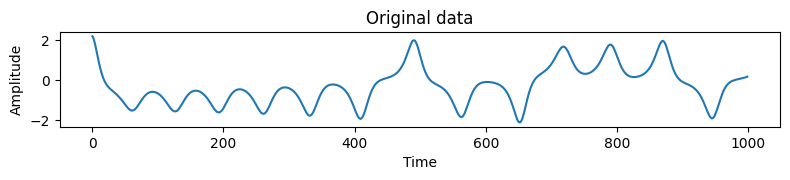

In [2]:
# @title Data reshaping

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv

nan_indices = np.where(np.isnan(data))
data = np.delete(data, nan_indices)

# standardization
mean_value = np.mean(data)
std_dev = np.std(data)
data = (data - mean_value) / std_dev

print('Data shape:',data.shape)

#######
#Visualization

plt.figure(figsize=(8, 3))

plt.subplot(2, 1, 1)
plt.plot(data[:1000])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [3]:
# @title Training period
T_train = 5000

In [4]:
# @title Data reshaping and loading libraries

%%time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import backend as K
import os
from contextlib import redirect_stdout

###############################
#MAE and RMSE
###############################
from sklearn.metrics import mean_absolute_error

def MAE(data1_in, data2_in):
    mae = mean_absolute_error(data1_in, data2_in)
    return mae

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

################################
# Hyperparameters

timesteps = 28  # Using data from past timesteps (corresponding to lag = 1 in a reservoir of dim*lag)
features = 1    # Data dimension (1 for a 1D time series)
################################

# reshaping the data
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(data[:T_train], timesteps)

CPU times: user 3.62 s, sys: 490 ms, total: 4.11 s
Wall time: 4.22 s


In [5]:
# @title Implement LSTM (TensorFlow)

%%time

Node        = 70
MAX_TRIALS  = 8    # Repeat the same thing while shifting each one step to produce robust result
T_test      = 100  # Forecast period

test_num    = 3000 # Number of times for one test (to get one generalization error in MAE)
synchro_len = 170  # Steps to generate initial hidden layer vector

epochs      = 20
batch_size  = 100


mean_score  = []
score       = []

##########################################
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import regularizers
##########################################

for trial in range(MAX_TRIALS):
    print(f"Trial {trial + 1}/{MAX_TRIALS}")

    # モデルの構築


    model = Sequential([
    LSTM(units=70, input_shape=(timesteps, features)),  # ← without regularization
    Dense(
        1,
        kernel_regularizer=regularizers.l2(1e-4)  # ← regulariation only for Dense layer
    )
    ])

    model.compile(optimizer='adam', loss=rmse)

    # Training
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)


    # Initialization of test data
    test_D = np.zeros((T_test,test_num))

    # Generating teacher data
    for t in range(test_num):

        test_D[:,t] = data[T_train+t:T_train+t+T_test]

    predictions = np.zeros((T_test, test_num))

    # Prepare initial data (shape: test_num * timesteps * features)
    current_sequences = np.array([
        data[T_train + t - timesteps : T_train + t].reshape(timesteps, features)
        for t in range(test_num)
    ])

    for step in range(T_test):

        with open(os.devnull, 'w') as f, redirect_stdout(f):
            pred = model.predict(current_sequences, verbose=0)  # shape: (test_num, 1)

        # save results
        predictions[step, :] = pred[:, 0]

        # sequence update (removing the oldest value and appending the new prediction)
        current_sequences = np.concatenate([
            current_sequences[:, 1:, :],              # shift t=1〜T-1
            pred[:, np.newaxis, :]                    # shape: (test_num, 1, 1)
        ], axis=1)  # shape: (test_num, timesteps, features)

#############

    mae = MAE( predictions[T_test-1,:],test_D[T_test-1,:])

    score.append(mae)
    mean_score.append(np.mean(score))

    print('MAE:',mae)
    print('Average of MAE:',np.mean(score))

Trial 1/8
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.4528
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0569
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0205
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0126
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0108
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0083
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0088
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0095
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0077
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0088
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0067
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0058
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0058
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0069
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0058
Epoch 16/20
50/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.4827
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0634
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0203
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0119
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0120
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0086
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0072
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0064
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0066
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0083
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0084
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0072
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0074
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0069
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0070
Epoch 16/20
50/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.6698
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0698
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0218
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0118
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0111
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0101
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0085
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0079
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0068
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0076
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0085
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0083
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0068
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0074
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0068
Epoch 16/20
50/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.6929
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0959
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0234
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0129
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0085
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0099
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0084
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0075
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0068
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0071
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0083
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0072
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0064
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0076
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0061
Epoch 16/20
50/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.5953
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0637
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0179
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0134
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0097
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0091
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0086
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0085
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0076
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0083
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0069
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0072
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0070
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0073
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0069
Epoch 16/20
50/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.5002
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0641
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0233
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0110
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0087
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0084
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0069
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0074
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0065
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0070
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0058
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0067
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0066
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0072
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0064
Epoch 16/20
50/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.5949
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0752
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0211
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0131
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0126
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0089
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0108
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0087
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0092
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0065
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0082
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0065
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0068
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0076
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0062
Epoch 16/20
50/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.5494
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0804
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0212
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0133
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0103
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0089
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0133
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0086
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0071
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0068
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0075
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0059
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0066
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0078
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0060
Epoch 16/20
50/

Average of MAE: 0.6446851030715137


/tmp/ipython-input-3822622476.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()#loc='lower right')


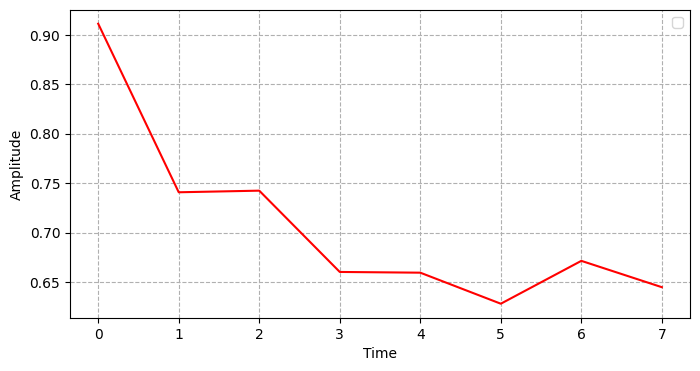

In [6]:
# @title Result of LSTM prediction

mean_score = np.array(mean_score)

import matplotlib.pyplot as plt

print('Average of MAE:',mean_score[MAX_TRIALS-1])

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(mean_score, color = "red")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()

MAE(the last trial): 0.45821889760080264
forecast period: 100


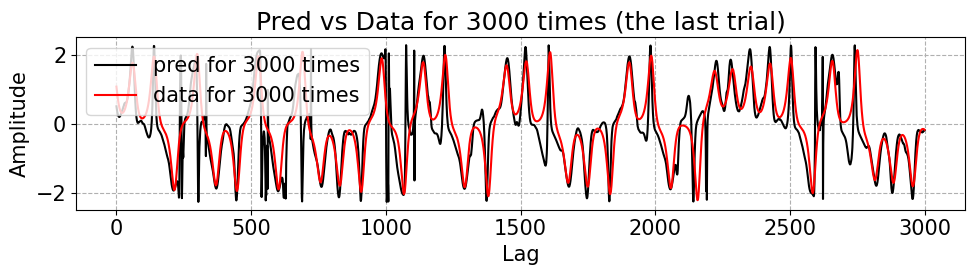

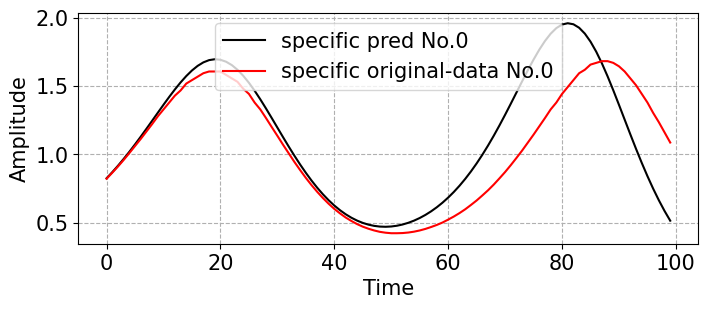

In [7]:
# @title Visualization (only the last trial)

print("MAE(the last trial):", mae)
print("forecast period:", T_test)

fig = plt.figure(figsize=(10,3), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Amplitude")
plt.title(f"Pred vs Data for {test_num} times (the last trial)")
plt.plot(predictions[T_test-1,:], color="black", label=f"pred for {test_num} times")
plt.plot(test_D[T_test-1,:], color = "red",label=f"data for {test_num} times")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

#####################
T_fix = 0
#####################

# Running Test Predictions
plt.figure(figsize=(8, 3))
plt.plot(predictions[:,T_fix], color = "black",label=f"specific pred No.{T_fix}")
plt.plot(test_D[:,T_fix], color = "red",label=f"specific original-data No.{T_fix}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()